In [1]:
import mhkit
from mhkit.wave import resource
from mhkit.wave.io import ndbc
import matplotlib.pyplot as plt
from matplotlib import colors 
import pandas as pd
import numpy as np
import calendar

In [2]:
parameter = 'swden'
buoy_number = '46050' 
ndbc_available_data= ndbc.available_data(parameter, buoy_number)
years_of_interest = ndbc_available_data[ndbc_available_data.year < 2013]
filenames= years_of_interest['filename']
ndbc_requested_data = ndbc.request_data(parameter, filenames)

In [3]:
ndbc_data={}
# Create a Datetime Index and remove NOAA date columns for each year
for year in ndbc_requested_data:
    year_data = ndbc_requested_data[year]
    ndbc_data[year] = ndbc.to_datetime_index(parameter, year_data)

In [4]:
res = resource.energy_flux(ndbc_data['1996'].T,h=399.)

In [5]:
# Intialize empty lists to store the results from each year
Hm0_list=[]
Te_list=[]
J_list=[]
Tp_list=[]

# Iterate over each year and save the result in the initalized dictionary
for year in ndbc_data:
    year_data = ndbc_data[year]
    Hm0_list.append(resource.significant_wave_height(year_data.T))
    Te_list.append(resource.energy_period(year_data.T))
    J_list.append(resource.energy_flux(year_data.T, h=399.))
    Tp_list.append(resource.peak_period(year_data.T))

# Concatenate list of Series into a single DataFrame
Te = pd.concat(Te_list ,axis=0)
Tp = pd.concat(Tp_list ,axis=0)
Hm0 = pd.concat(Hm0_list ,axis=0)
J = pd.concat(J_list ,axis=0)
data = pd.concat([Hm0, Te, Tp, J],axis=1)

# Drop any NaNs created from the calculation of Hm0 or Te
data.dropna(inplace=True)
# Sort the DateTime index
data.sort_index(inplace=True)
data

C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, m

,Hm0,Te,Tp,J
date,,,,
1996-01-01 00:00:00,77.935358,7.311955,33.333333,2.230499e+07
1996-01-01 01:00:00,5.215669,13.120481,16.666667,1.752212e+05
1996-01-01 02:00:00,4.582576,12.233122,14.285714,1.260913e+05
1996-01-01 03:00:00,4.968219,12.652905,14.285714,1.532625e+05
1996-01-01 04:00:00,4.432245,12.294969,12.500000,1.185388e+05
...,...,...,...,...
2012-12-31 19:00:00,2.955808,14.530107,17.391304,6.228156e+04
2012-12-31 20:00:00,2.626937,13.967092,17.391304,4.727815e+04
2012-12-31 21:00:00,2.826730,13.612849,16.000000,5.334528e+04


## Annual Scatter Table

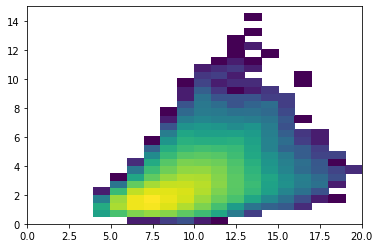

In [6]:
# Remove Hm0 Outliers
data_clean = data[data.Hm0 < 20]
sigma = data_clean.J.std()
data_clean = data_clean[data_clean.J > (data_clean.J.mean() - 0.9* sigma)]
#data_clean = data_clean[data_clean.J < data_clean.J.mean() + 3* data_clean.J.std()]

Hm0_bin_size = 0.5
Hm0_edges = np.arange(0,15+Hm0_bin_size,Hm0_bin_size)


Te_bin_size = 1
Te_edges = np.arange(0, 20+Te_bin_size,Te_bin_size)
Te_edges

h= plt.hist2d(data_clean.Te,  
           data_clean.Hm0, 
           bins = (Te_edges,Hm0_edges), 
           norm = colors.LogNorm())

In [7]:
data.describe()

,Hm0,Te,Tp,J
count,127994.000000,127994.000000,127994.000000,1.279940e+05
mean,3.227731,8.936628,10.998353,2.717057e+05
std,7.794570,2.037081,3.825764,2.260086e+06
min,0.120000,4.037509,2.941176,4.251706e+01
25%,1.536229,7.362985,8.333333,8.829633e+03
50%,2.134666,8.709283,10.810811,1.905313e+04
75%,3.053326,10.199964,12.500000,4.555719e+04
max,77.935358,20.743978,33.333333,2.230499e+07


## Wave Power by Month

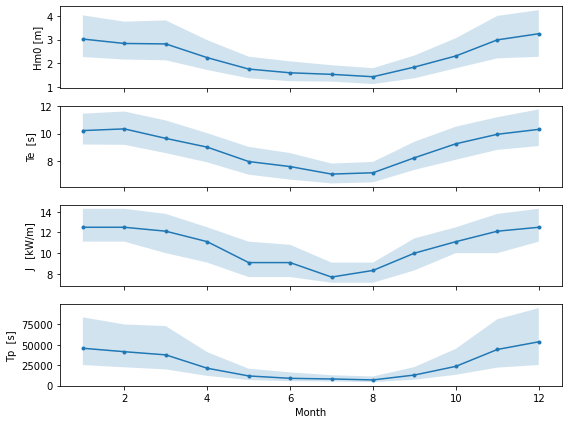

In [23]:
months=data_clean.index.month
data_group=data_clean.groupby(months)
# 3 plots
QoIs = data_clean.keys()
fig, axs = plt.subplots(len(QoIs),1, figsize=(8, 6), sharex=True)
#shade between 25% and 75%
QoIs = data_clean.keys()
for i in range(len(QoIs)):
    QoI = QoIs[i]
    axs[i].plot(data_group.median()[QoI], marker='.')

    axs[i].fill_between(months.unique(),
                        data_group.describe()[QoI,   '25%'],
                        data_group.describe()[QoI,   '75%'],
                        alpha=0.2)

plt.setp(axs[3], xlabel='Month')
plt.setp(axs[0], ylabel='Hm0 [m]')

plt.setp(axs[1], ylabel='Te  [s]')
plt.setp(axs[2], ylabel='J   [kW/m]')
plt.setp(axs[3], ylabel='Tp  [s]')

plt.tight_layout()

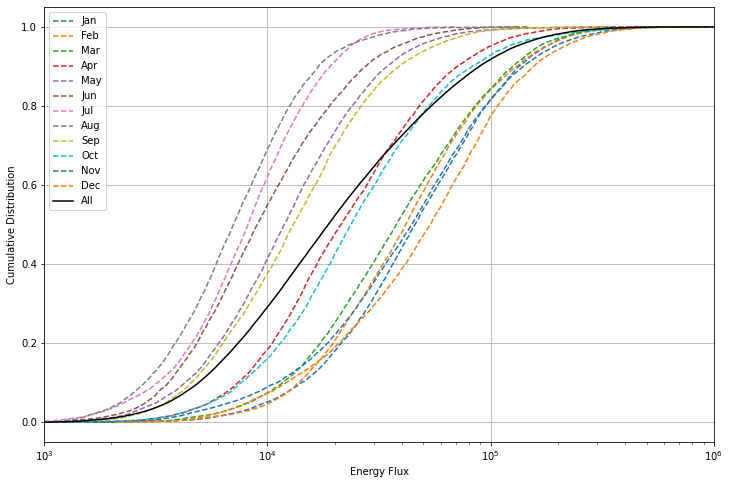

In [9]:
cumSum={}
for month in data_clean.index.month.unique():    
    F = mhkit.river.resource.exceedance_probability(data_clean[data_clean.index.month==month].J)
    cumSum[month] = 1-F/100
    cumSum[month].sort_values('F', inplace=True)
plt.figure(figsize=(12,8) )
for month in data_clean.index.month.unique():
    plt.semilogx(data_clean.loc[cumSum[month].index].J, cumSum[month].F, '--', label=calendar.month_abbr[month])

F = mhkit.river.resource.exceedance_probability(data_clean.J)
F.sort_values('F', inplace=True)
plt.semilogx(data_clean.loc[F.index].J, 1-F/100, 'k-', fillstyle='none', label='All')

plt.xlim([1000, 1E6])    
plt.grid()
plt.xlabel('Energy Flux')
plt.ylabel('Cumulative Distribution')
plt.legend()

In [10]:
data_clean

,Hm0,Te,Tp,J
date,,,,
1996-01-01 01:00:00,5.215669,13.120481,16.666667,175221.249813
1996-01-01 02:00:00,4.582576,12.233122,14.285714,126091.304257
1996-01-01 03:00:00,4.968219,12.652905,14.285714,153262.455327
1996-01-01 04:00:00,4.432245,12.294969,12.500000,118538.780103
1996-01-01 05:00:00,4.425924,12.832110,14.285714,123386.849024
...,...,...,...,...
2012-12-31 19:00:00,2.955808,14.530107,17.391304,62281.560742
2012-12-31 20:00:00,2.626937,13.967092,17.391304,47278.147236
2012-12-31 21:00:00,2.826730,13.612849,16.000000,53345.280756


In [11]:
ndbc_data['1996'] = ndbc_data['1996'][ndbc_data['1996'] != 999.0].dropna()
ndbc_data['1996'].to_csv('46050_1996.csv')

In [12]:
ndbc_data['1996'].head()

,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,...,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40
date,,,,,,,,,,,,,,,,,,,,,
1996-01-01 01:00:00,0.14,0.88,11.75,40.21,35.99,23.97,12.87,9.97,5.65,4.77,...,0.07,0.07,0.05,0.06,0.06,0.06,0.06,0.04,0.03,0.03
1996-01-01 02:00:00,0.11,0.46,6.73,22.24,22.54,17.98,15.50,10.37,9.44,7.20,...,0.11,0.11,0.07,0.08,0.07,0.05,0.06,0.04,0.03,0.02
1996-01-01 03:00:00,0.11,0.35,8.02,28.71,32.57,28.12,14.27,8.82,7.51,4.62,...,0.09,0.10,0.08,0.07,0.04,0.05,0.06,0.04,0.02,0.03
1996-01-01 04:00:00,0.08,0.42,6.34,18.72,20.53,23.50,15.63,9.24,7.60,4.42,...,0.13,0.07,0.09,0.10,0.06,0.05,0.04,0.03,0.03,0.03
1996-01-01 05:00:00,0.14,0.34,7.23,25.57,27.11,16.50,11.61,7.95,6.99,3.21,...,0.13,0.10,0.09,0.09,0.10,0.06,0.04,0.03,0.03,0.03


In [19]:
from sklearn.mixture import GaussianMixture

# Compute Gaussian Mixture Model
N=8
X = np.vstack((data_clean.Te.values, data_clean.Hm0.values)).T
gmm = GaussianMixture(n_components=8).fit(X)

# Save centers and weights
results = pd.DataFrame(gmm.means_, columns=['Te','Hm0'])
results['weights'] = gmm.weights_

results['Tp'] = results.Te / 0.858

results

,Te,Hm0,weights,Tp
0,6.429672,1.543356,0.171399,7.493790
1,8.866999,3.044480,0.119704,10.334497
2,12.227291,5.465116,0.040811,14.250922
3,10.721493,2.534023,0.130299,12.495913
4,9.180184,1.815288,0.160490,10.699516
5,7.644699,1.734588,0.233919,8.909905
6,12.777413,3.073976,0.056212,14.892090
7,10.491669,4.289725,0.087166,12.228052


Text(0, 0.5, 'Sig. wave height, $Hm0$ [m]')

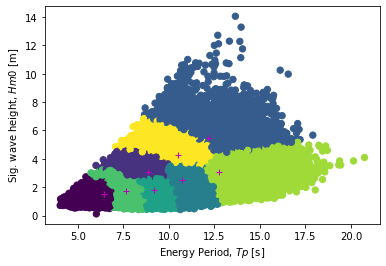

In [20]:
# Plot the Sections of Data
labels = gmm.predict(X)
plt.scatter(data_clean.Te.values, data_clean.Hm0.values, c=labels, s=40)
plt.plot(results.Te, results.Hm0, 'm+')
plt.xlabel('Energy Period, $Tp$ [s]')
plt.ylabel('Sig. wave height, $Hm0$ [m]')

In [24]:
Hm0_bins = np.arange(0, data_clean.Hm0.max() + .5, .5)    
Te_bins = np.arange(0, data_clean.Te.max() + 1, 1)
JM = mhkit.wave.performance.wave_energy_flux_matrix(data_clean.Hm0, data_clean.Te, data_clean.J, 'mean', Hm0_bins, Te_bins)

#L = mhkit.wave.performance.capture_length(P, data_clean.J) 

#maep_timeseries = mhkit.wave.performance.mean_annual_energy_production_timeseries(L, data_clean.J)
#print("MAEP from timeseries = ", maep_timeseries)

NameError: name 'wave' is not defined